## Visualizing various Model Selection chain outputs

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import json

In [3]:
import sys
sys.path.insert(0,'/Users/hazboun/software_development/la_forge/')
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec

In [4]:
psrname = 'J1911+1347'
chaindir = '/Users/hazboun/nanograv_detection/ent_ext_testing/{}/nondiag_dmgp/'.format(psrname)

In [62]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 6850
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


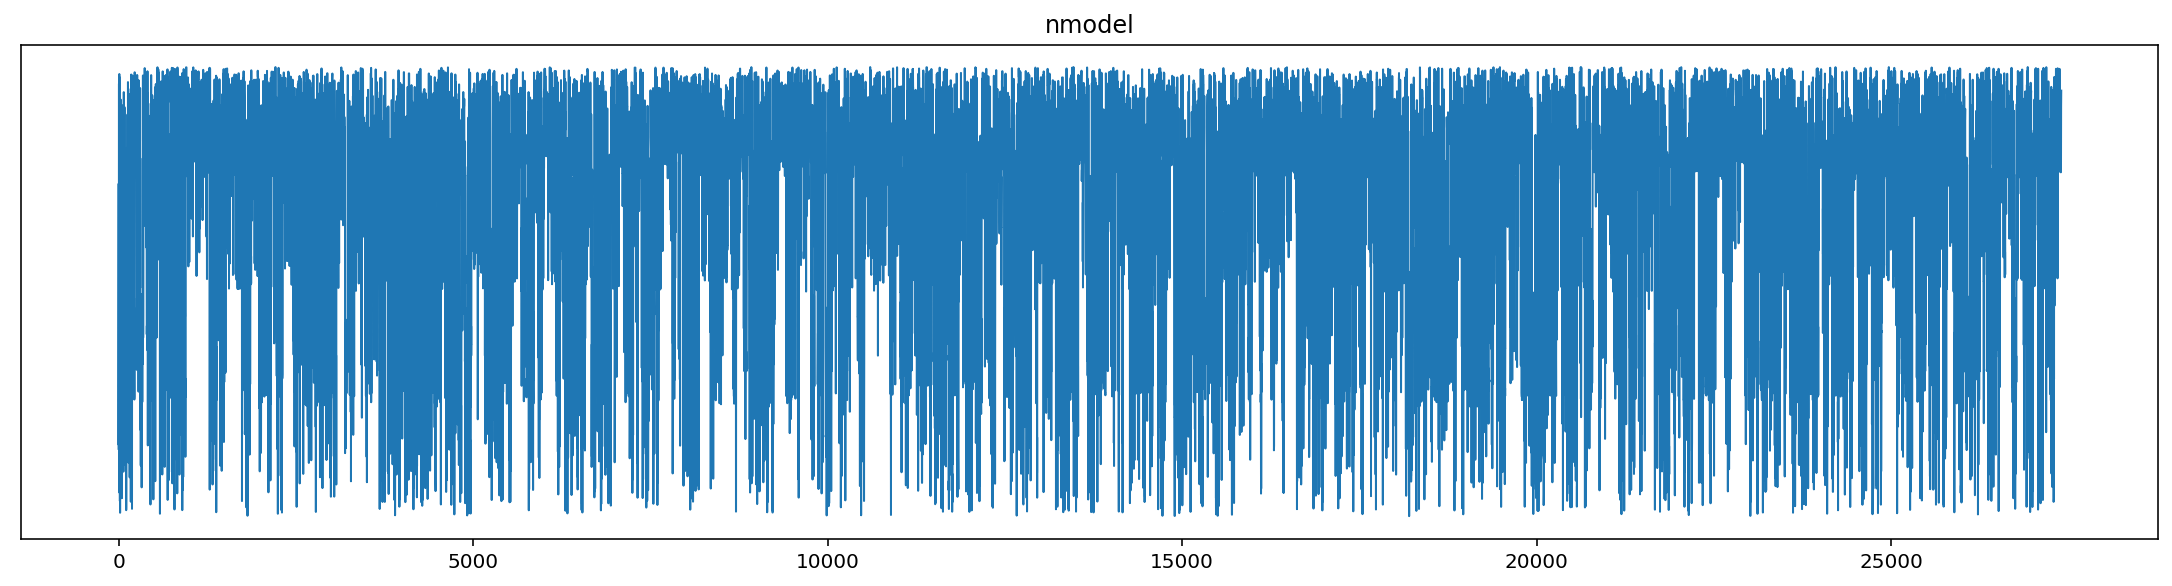

In [63]:
dg.plot_chains(cH,hist=False,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='')

In [64]:
with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_dict=json.load(fin)

In [39]:
# model_dict

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters

In [58]:
c1=cH.model_core(1)
c3=cH.model_core(3)

In [59]:
c1.params

['J1911+1347_430_PUPPI_efac',
 'J1911+1347_430_PUPPI_log10_ecorr',
 'J1911+1347_430_PUPPI_log10_equad',
 'J1911+1347_L-wide_PUPPI_efac',
 'J1911+1347_L-wide_PUPPI_log10_ecorr',
 'J1911+1347_L-wide_PUPPI_log10_equad',
 'J1911+1347_dm_gp_log10_ell',
 'J1911+1347_dm_gp_log10_sigma',
 'J1911+1347_red_noise_gamma',
 'J1911+1347_red_noise_log10_A']

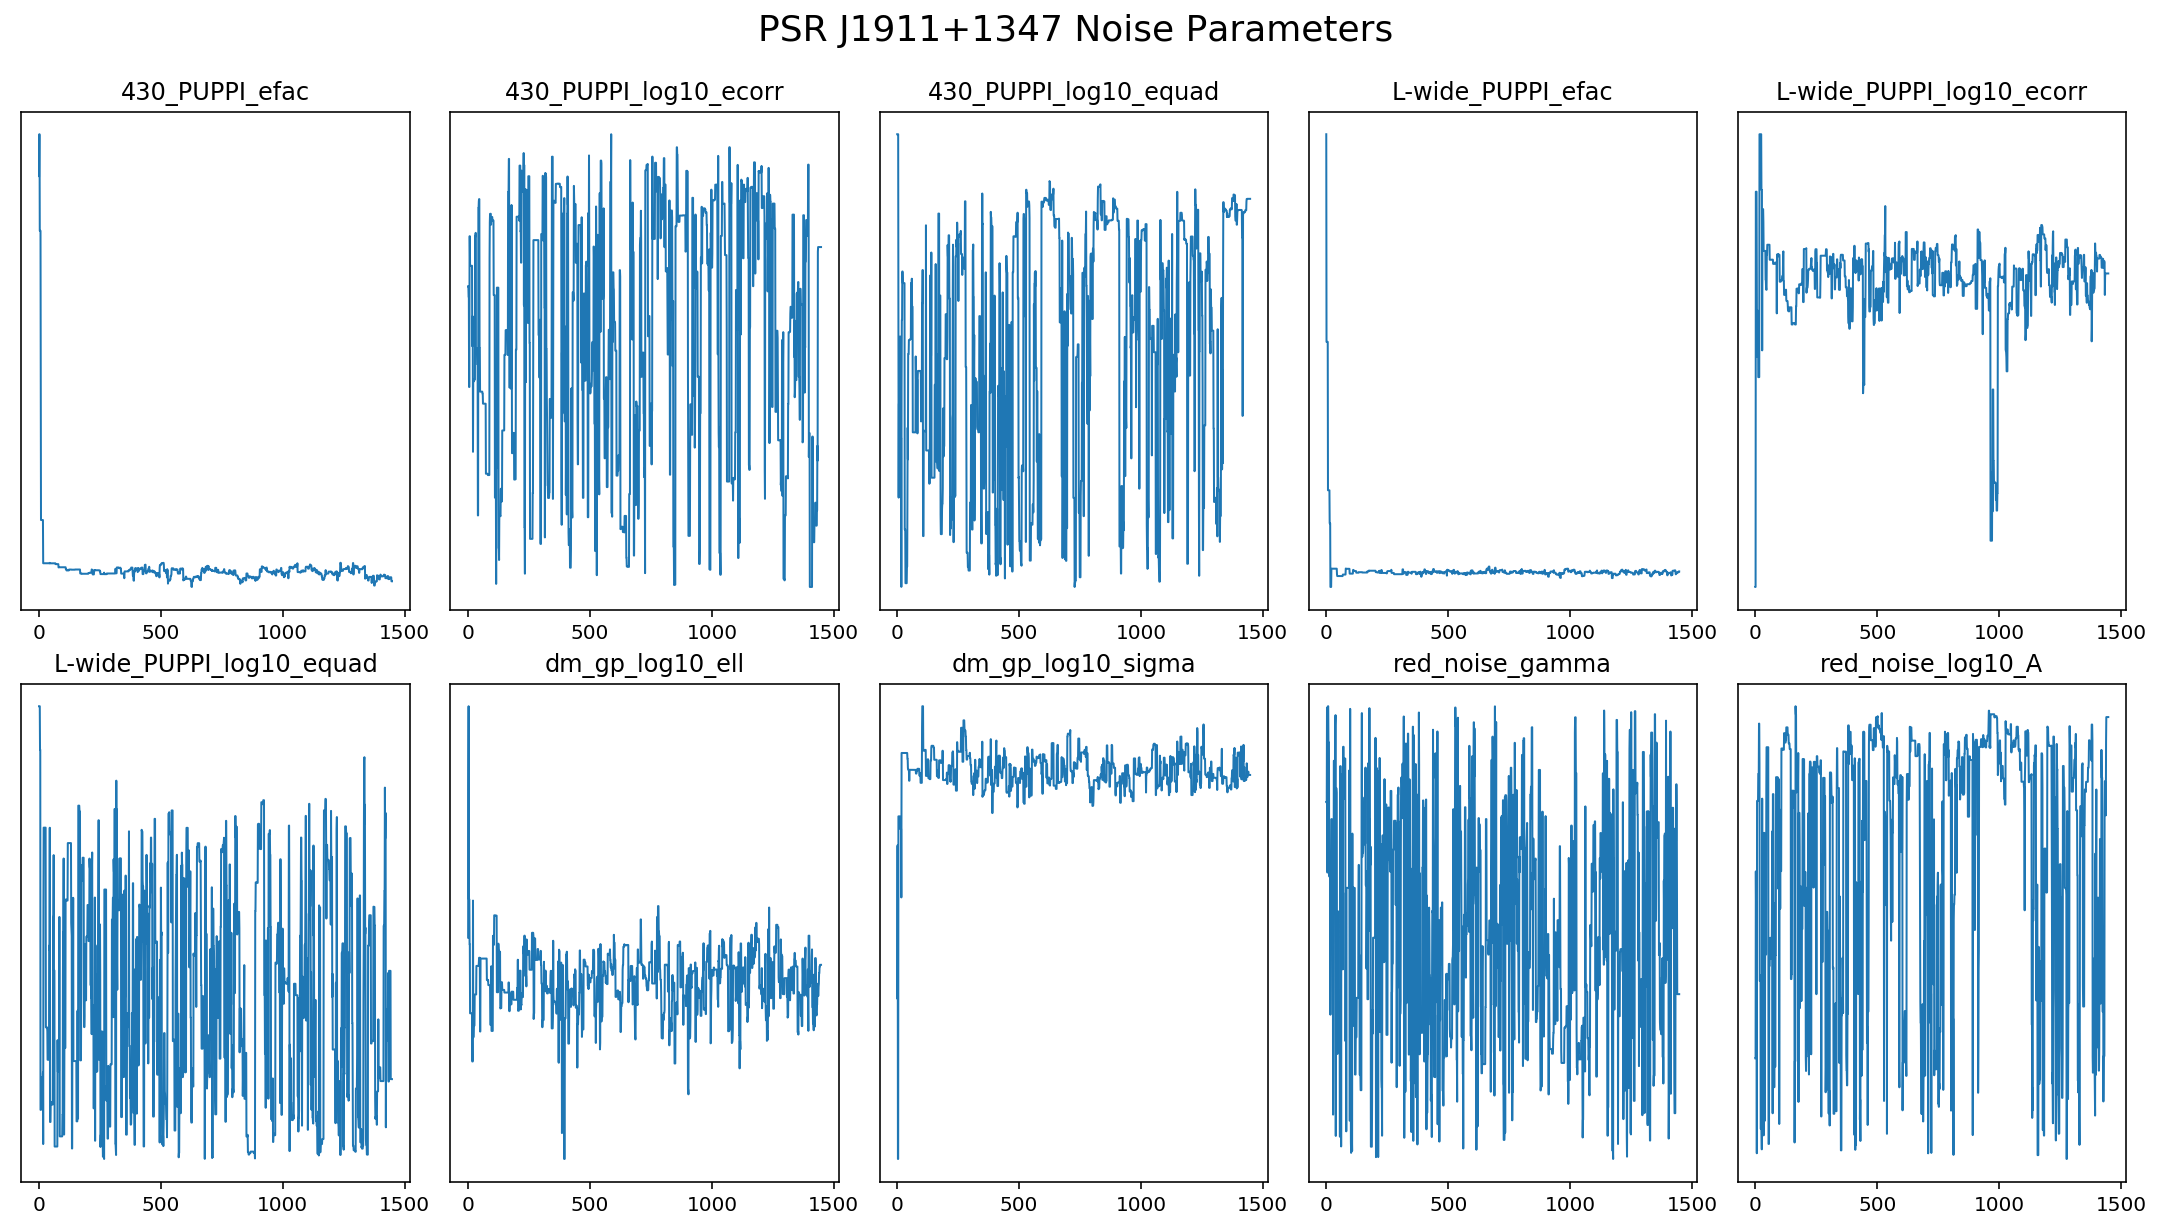

In [65]:
dg.plot_chains(c1, hist=False, ncols=5, title_y=1.05)

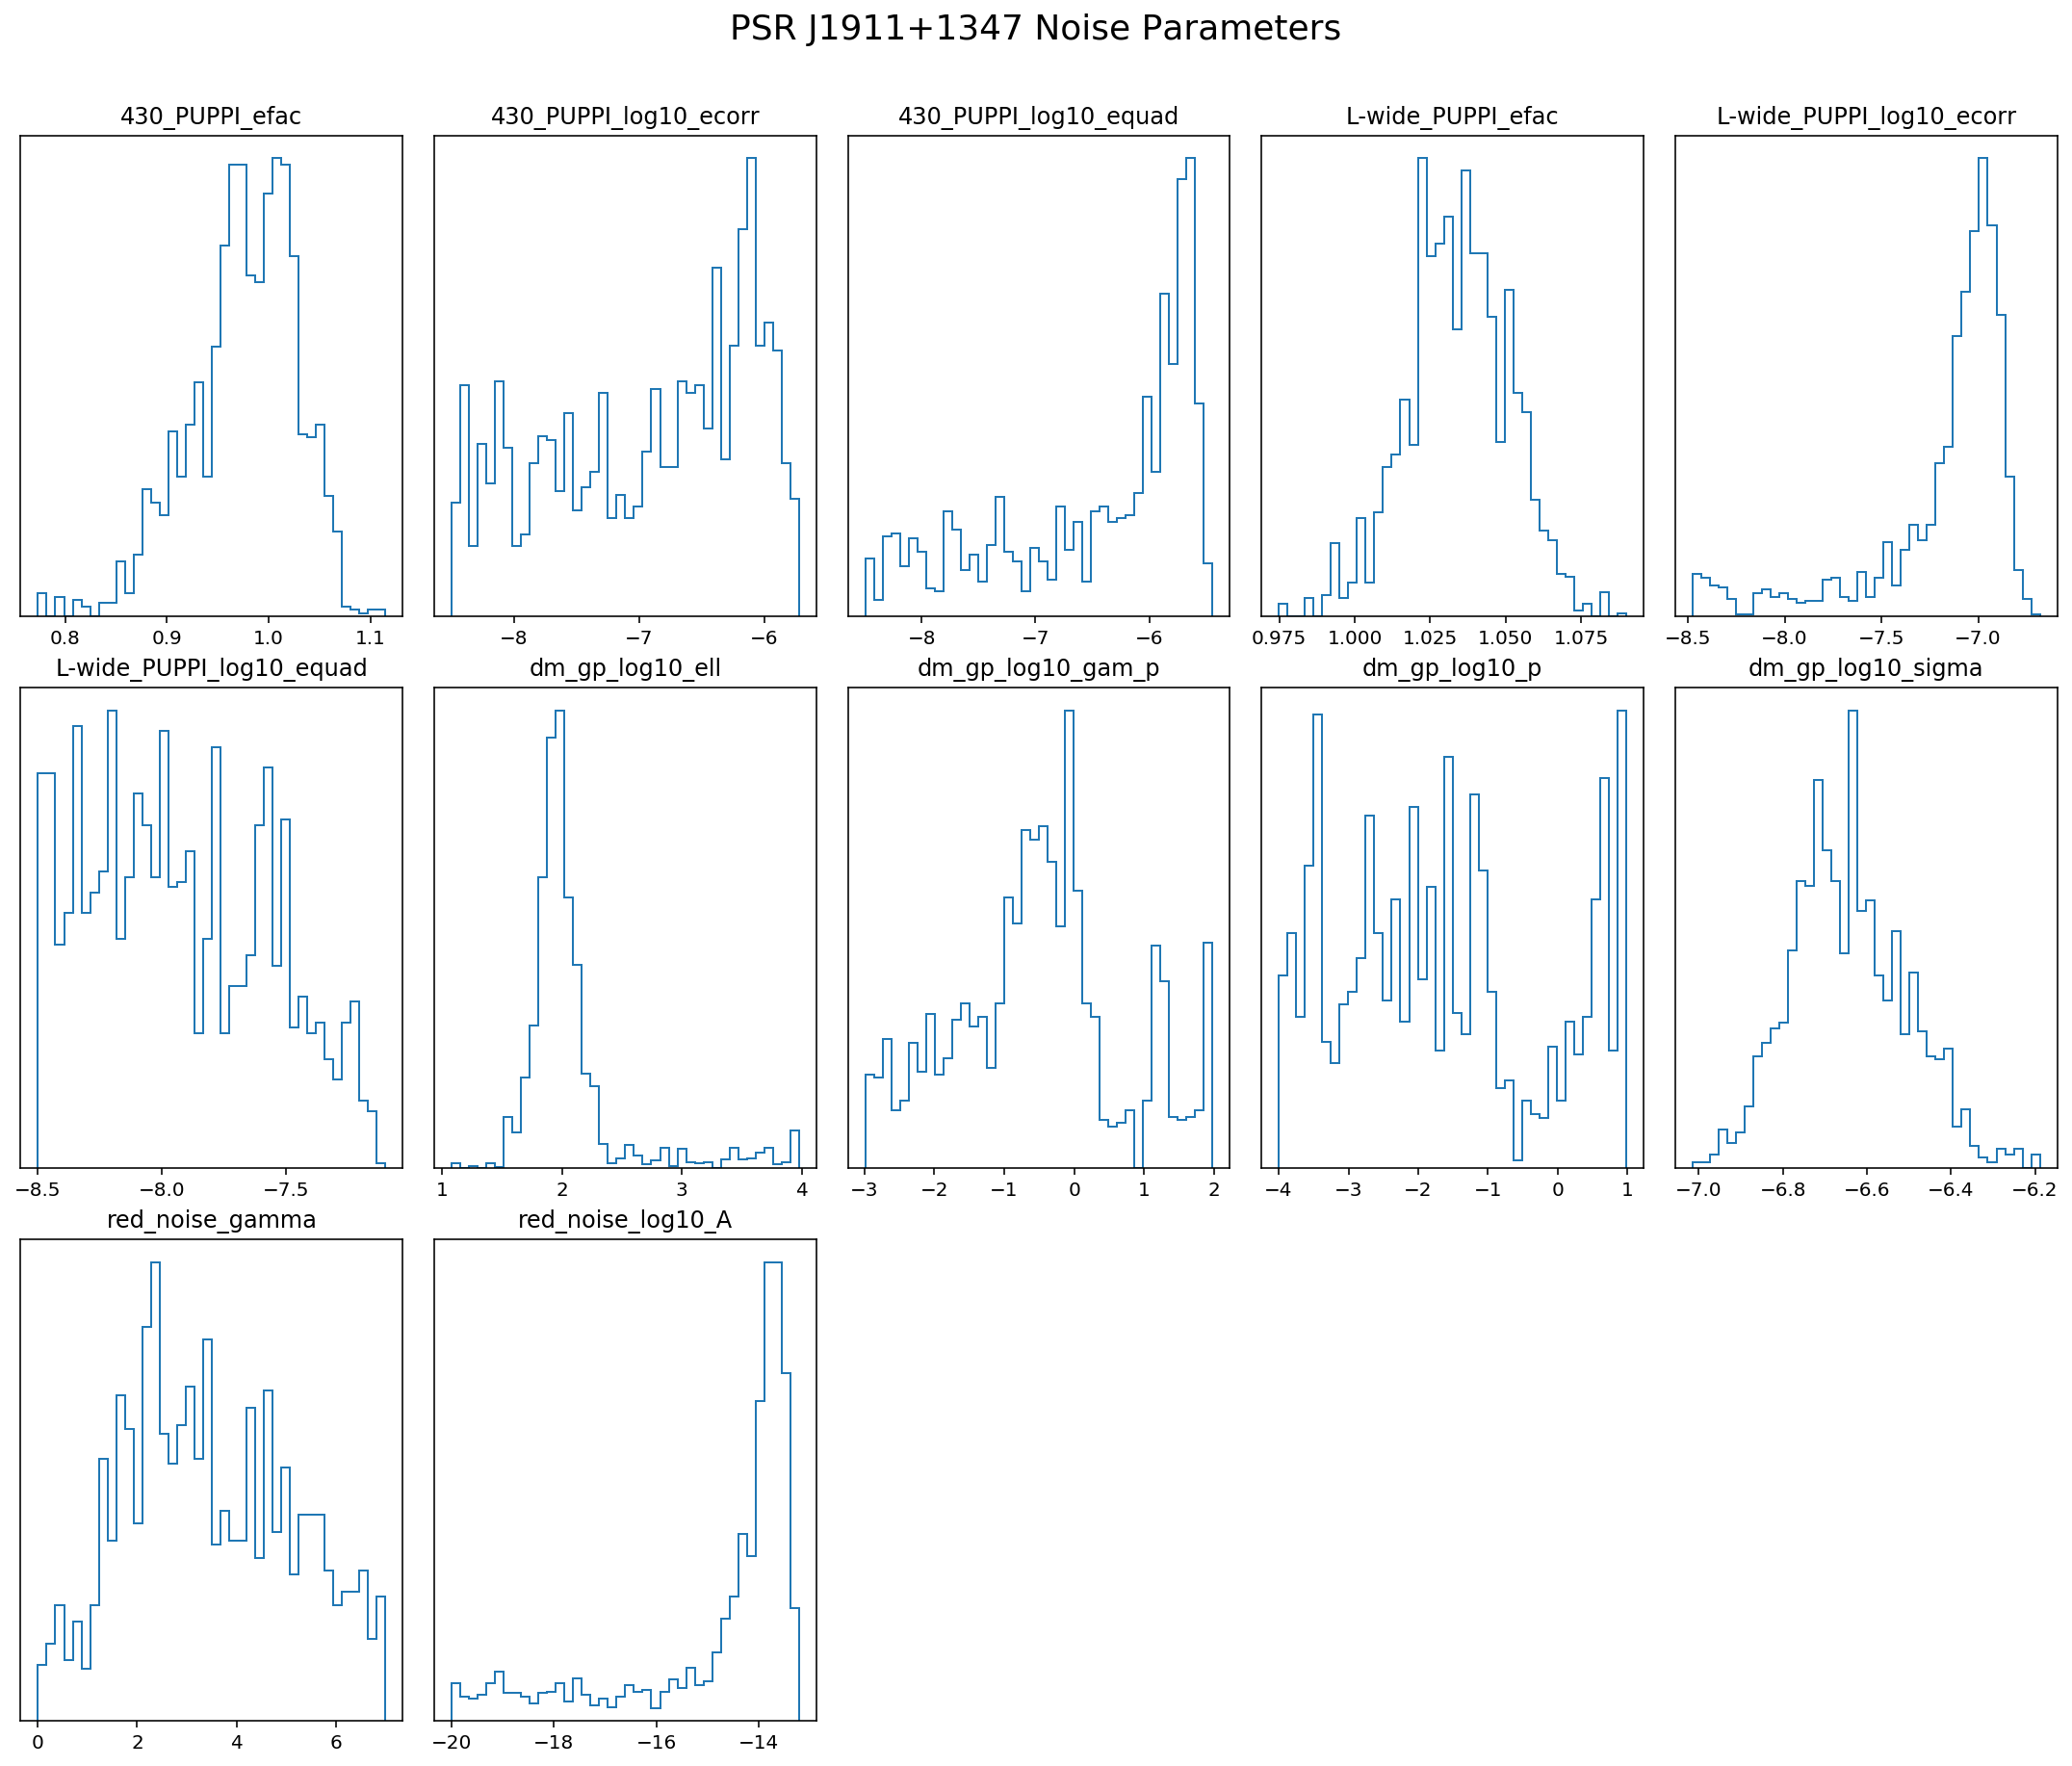

In [66]:
dg.plot_chains(c3, hist=True, ncols=5, title_y=1.05)

In [92]:
model_labels=[['rn_plaw', 'dm_sq_exp', True],
              ['rn_plaw', 'dm_sq_exp', False],
              ['rn_plaw', 'dm_periodic', True],
              ['rn_plaw', 'dm_periodic', False],
              ]
model_labels=np.array(model_labels)

In [93]:
model_labels

array([['rn_plaw', 'dm_sq_exp', 'True'],
       ['rn_plaw', 'dm_sq_exp', 'False'],
       ['rn_plaw', 'dm_periodic', 'True'],
       ['rn_plaw', 'dm_periodic', 'False']], dtype='<U11')

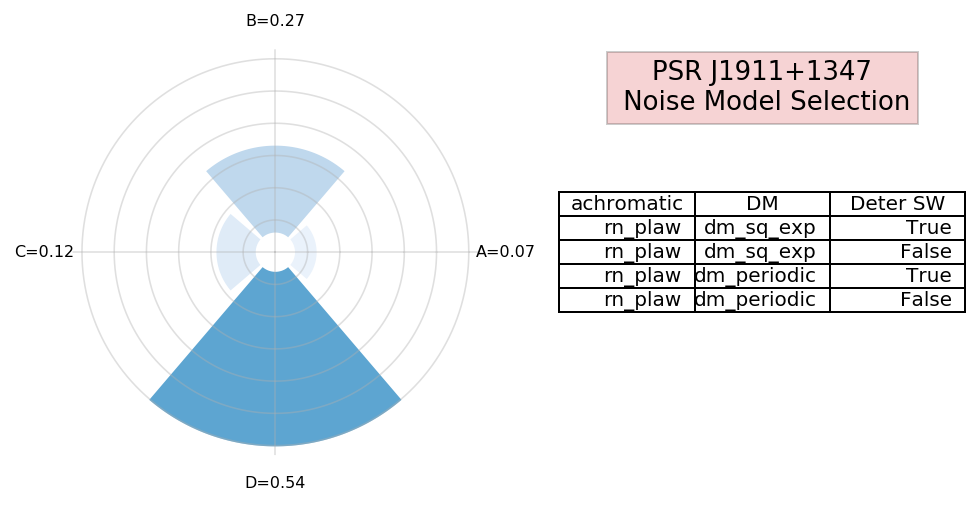

In [94]:
dg.noise_flower(cH, 
                colLabels=['achromatic', 'DM', 'Deter SW'],
                cellText=model_labels)

In [ ]:
plt.table()

## Plot DMX

## Gaussian Process Realizations

In [91]:
?np.histogram